Training Set Metrics:
Accuracy: 0.8381
Precision: 0.8181
Recall: 0.8695
F1 Score: 0.8430



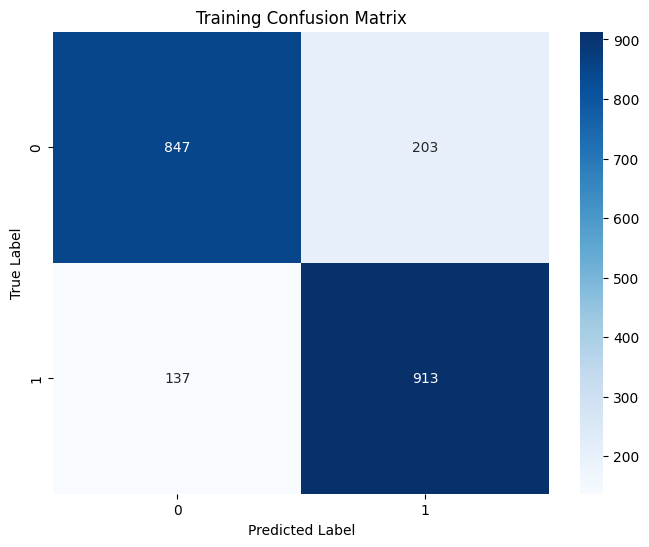

Validation Set Metrics:
Accuracy: 0.7533
Precision: 0.8115
Recall: 0.6600
F1 Score: 0.7279



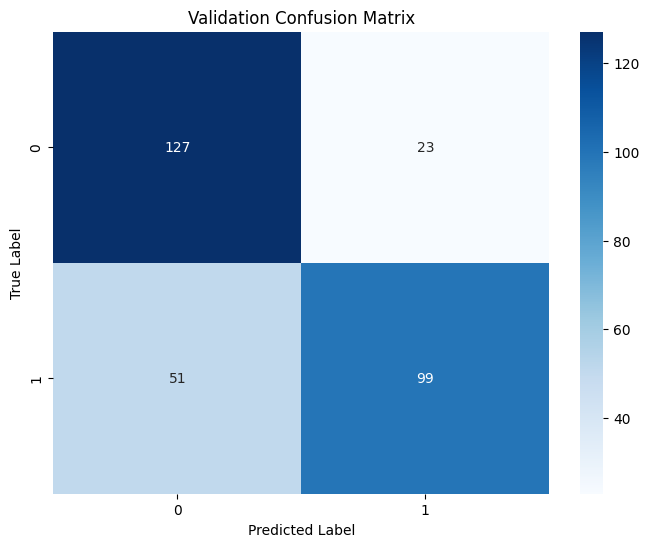

Test Set Metrics:
Accuracy: 0.7650
Precision: 0.8245
Recall: 0.6733
F1 Score: 0.7413



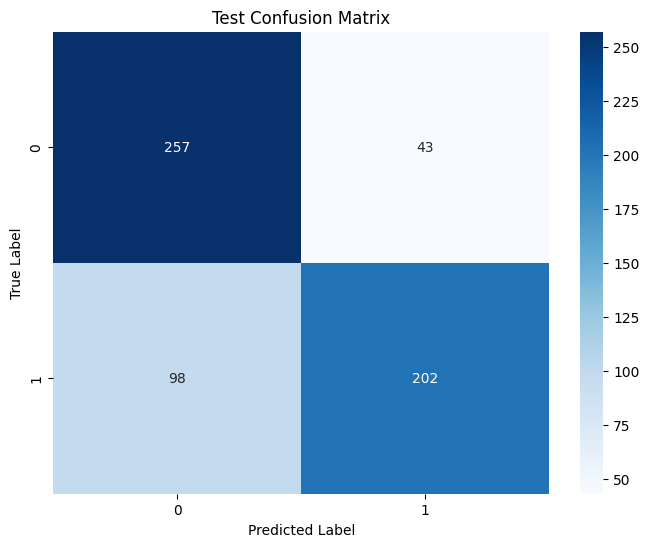

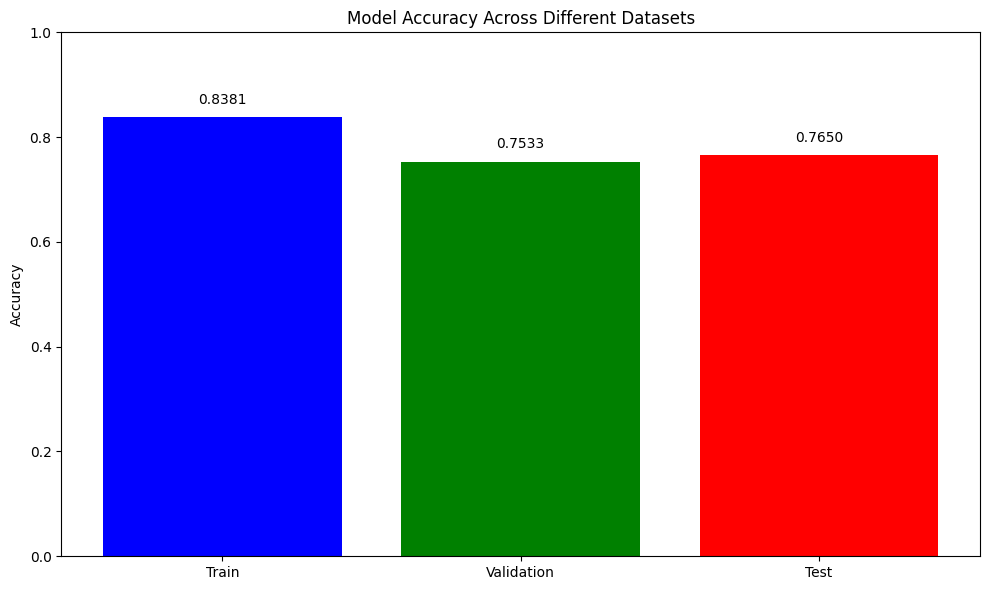

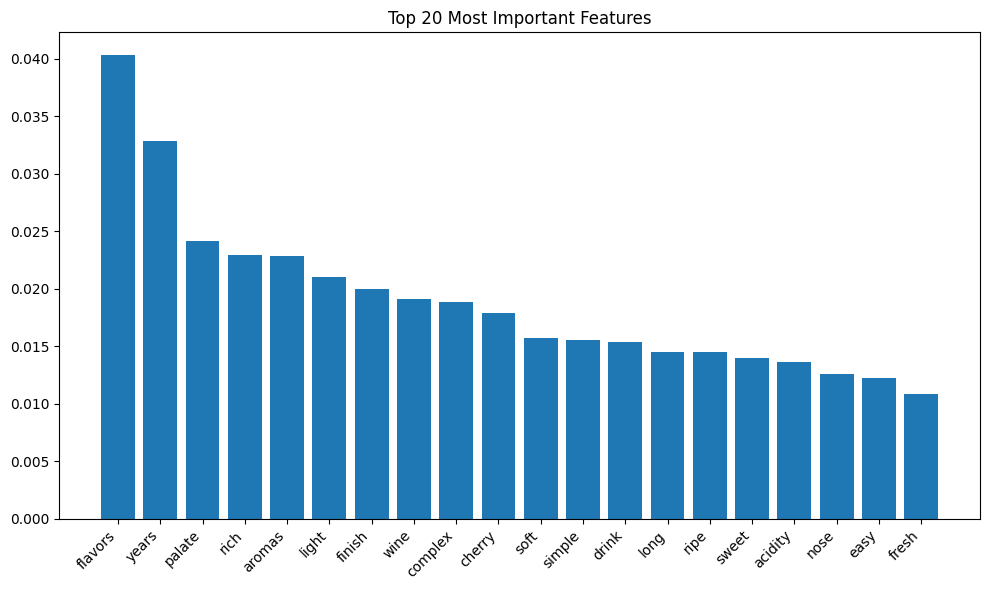


Example Predictions:

Review: An excellent wine with great balance and complexity. Rich flavors of dark fruit and oak.
Prediction: Liked
Confidence: 0.548

Review: Simple and straightforward. Somewhat bland with little character.
Prediction: Not Liked
Confidence: 0.351

Review: Amazing depth with perfect tannins. A masterpiece of winemaking.
Prediction: Liked
Confidence: 0.503


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import joblib

class WineReviewClassifier:
    def __init__(self, vocab_size=5000, max_features=5000):
        """
        Initialize the Wine Review Classifier

        Parameters:
        -----------
        vocab_size : int, optional (default=5000)
            Maximum number of features to consider
        max_features : int, optional (default=5000)
            Maximum number of features for TF-IDF vectorization
        """
        self.vectorizer = TfidfVectorizer(
            max_features=max_features,
            stop_words='english',
            ngram_range=(1, 2)
        )
        self.classifier = RandomForestClassifier(
            n_estimators=300,
            max_depth=20,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42,
            class_weight='balanced'
        )
        self.le = LabelEncoder()

    def prepare_data(self, file_path):
        """
        Load and preprocess the wine review dataset

        Parameters:
        -----------
        file_path : str
            Path to the CSV file containing wine reviews

        Returns:
        --------
        X : array-like
            Preprocessed text reviews
        y : array-like
            Binary sentiment labels
        """
        # Load dataset
        df = pd.read_csv(file_path)

        # Keep only relevant columns
        df = df[['description', 'points']]

        # Convert ratings to binary sentiment
        df['sentiment'] = df['points'].apply(lambda x: 1 if x >= 90 else 0)

        # Prepare features and labels
        X = df['description'].astype(str)
        y = df['sentiment']

        return X, y

    def train(self, X_train, y_train):
        """
        Train the wine review classifier

        Parameters:
        -----------
        X_train : array-like
            Training text reviews
        y_train : array-like
            Training sentiment labels
        """
        # Convert labels
        y_train = self.le.fit_transform(y_train)

        # Vectorize text
        X_train_vectorized = self.vectorizer.fit_transform(X_train)

        # Train Random Forest classifier
        self.classifier.fit(X_train_vectorized, y_train)

    def evaluate(self, X, y, dataset_name=''):
        """
        Evaluate the model performance

        Parameters:
        -----------
        X : array-like
            Text reviews
        y : array-like
            Sentiment labels
        dataset_name : str, optional
            Name of the dataset for printing

        Returns:
        --------
        dict : Performance metrics
        """
        # Convert labels
        y_encoded = self.le.transform(y)

        # Vectorize text
        X_vectorized = self.vectorizer.transform(X)

        # Predictions
        y_pred = self.classifier.predict(X_vectorized)

        # Performance metrics
        accuracy = accuracy_score(y_encoded, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_encoded, y_pred, average='binary'
        )

        # Print metrics if dataset name is provided
        if dataset_name:
            print(f"{dataset_name} Set Metrics:")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}\n")
            cm = confusion_matrix(y_encoded, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'{dataset_name} Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

    def plot_accuracies(self, train_acc, val_acc, test_acc):
        """
        Plot accuracies for train, validation, and test sets

        Parameters:
        -----------
        train_acc : float
            Training set accuracy
        val_acc : float
            Validation set accuracy
        test_acc : float
            Test set accuracy
        """
        plt.figure(figsize=(10, 6))
        sets = ['Train', 'Validation', 'Test']
        accuracies = [train_acc, val_acc, test_acc]

        plt.bar(sets, accuracies, color=['blue', 'green', 'red'])
        plt.title('Model Accuracy Across Different Datasets')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)  # Set y-axis from 0 to 1

        # Add value labels on top of each bar
        for i, v in enumerate(accuracies):
            plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()


    def feature_importance(self):
        """
        Extract and visualize feature importances
        """
        # Get feature names
        feature_names = self.vectorizer.get_feature_names_out()

        # Extract feature importances
        importances = self.classifier.feature_importances_
        indices = np.argsort(importances)[::-1]

        # Plot top 20 features
        plt.figure(figsize=(10, 6))
        plt.title("Top 20 Most Important Features")
        plt.bar(range(20), importances[indices[:20]])
        plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def predict(self, review_text):
        """
        Predict sentiment for a new review

        Parameters:
        -----------
        review_text : str
            Text of the wine review

        Returns:
        --------
        prediction : int
            Predicted sentiment (0 or 1)
        probability : float
            Probability of positive sentiment
        """
        # Vectorize input
        review_vectorized = self.vectorizer.transform([review_text])

        # Predict
        prediction = self.classifier.predict(review_vectorized)
        probability = self.classifier.predict_proba(review_vectorized)[0][1]

        return prediction[0], probability

def main():
    # Initialize classifier
    classifier = WineReviewClassifier()

    # Load and prepare data
    file_path = "wine_small_balanced.csv"  # Update with your file path
    X, y = classifier.prepare_data(file_path)

    # First split: separate out test set (20%)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Second split: separate train (70%) and validation (10%) sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.125, random_state=42, stratify=y_train_val
    )

    # Train the model
    classifier.train(X_train, y_train)

    # Evaluate performance on all sets
    train_metrics = classifier.evaluate(X_train, y_train, 'Training')
    val_metrics = classifier.evaluate(X_val, y_val, 'Validation')
    test_metrics = classifier.evaluate(X_test, y_test, 'Test')

    # Plot accuracies
    classifier.plot_accuracies(
        train_metrics['accuracy'],
        val_metrics['accuracy'],
        test_metrics['accuracy']
    )

    # Visualize feature importance
    classifier.feature_importance()

    # Example predictions
    example_reviews = [
        "An excellent wine with great balance and complexity. Rich flavors of dark fruit and oak.",
        "Simple and straightforward. Somewhat bland with little character.",
        "Amazing depth with perfect tannins. A masterpiece of winemaking."
    ]

    print("\nExample Predictions:")
    for review in example_reviews:
        prediction, probability = classifier.predict(review)
        print(f"\nReview: {review}")
        print(f"Prediction: {'Liked' if prediction == 1 else 'Not Liked'}")
        print(f"Confidence: {probability:.3f}")

    # Save model and vectorizer
    joblib.dump(classifier.classifier, 'wine_review_rf_model.joblib')
    joblib.dump(classifier.vectorizer, 'wine_review_vectorizer.joblib')

if __name__ == "__main__":    main()

Training Set Metrics:
Accuracy: 0.8155
Precision: 0.6749
Recall: 0.8147
F1 Score: 0.7382



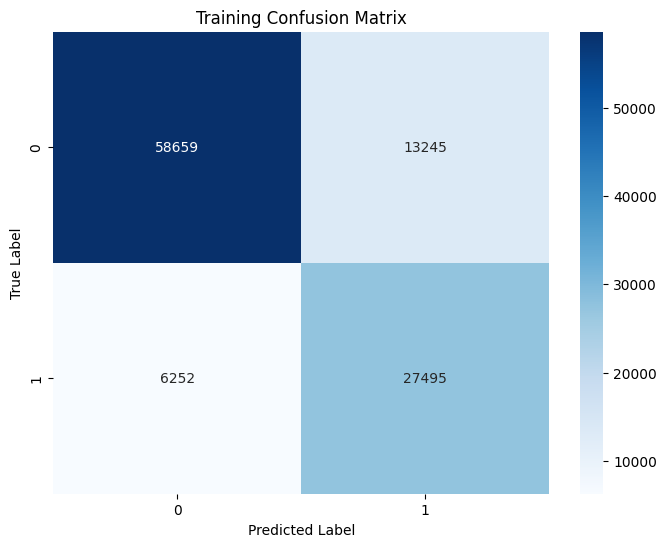

Validation Set Metrics:
Accuracy: 0.7948
Precision: 0.6484
Recall: 0.7814
F1 Score: 0.7087



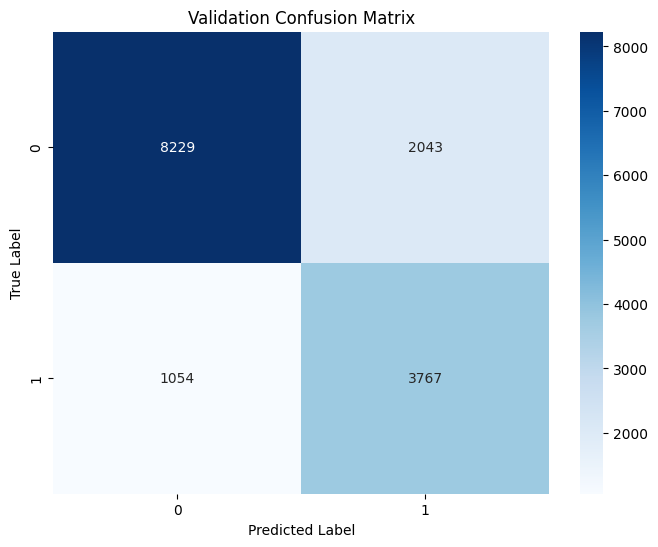

Test Set Metrics:
Accuracy: 0.7978
Precision: 0.6512
Recall: 0.7904
F1 Score: 0.7141



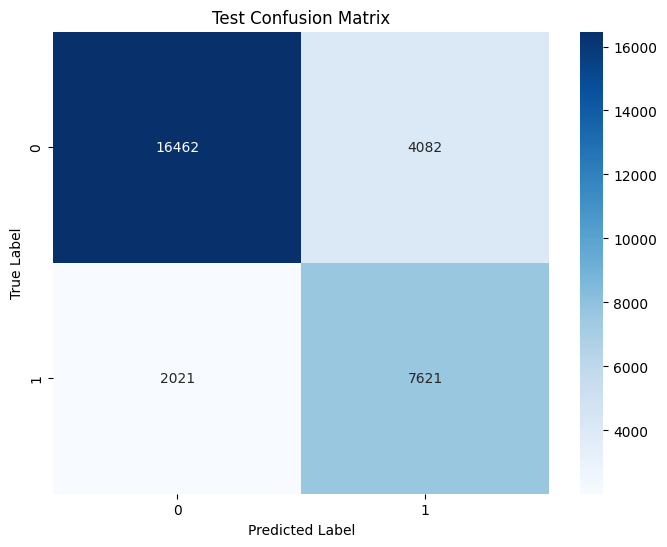

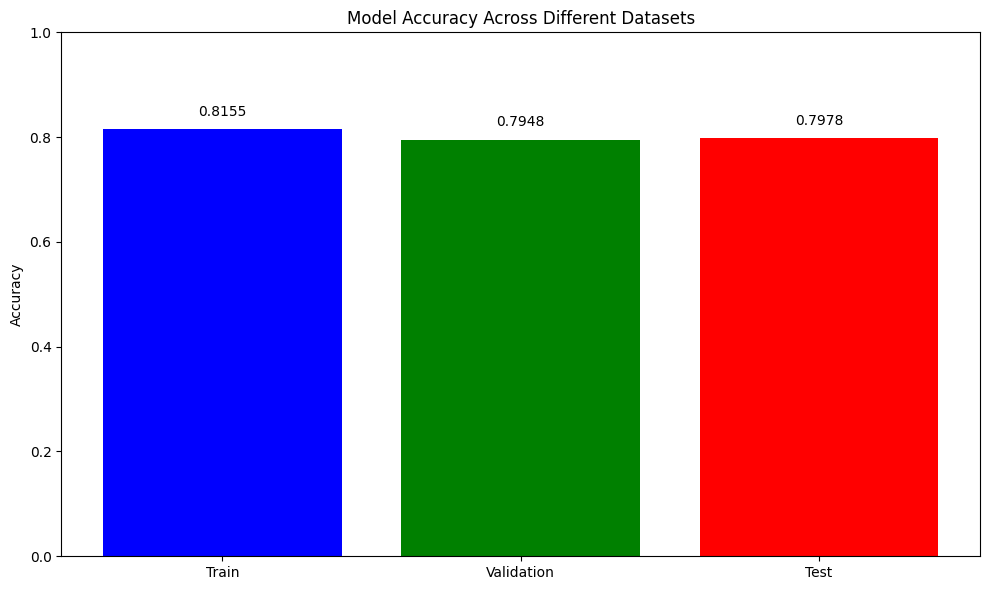

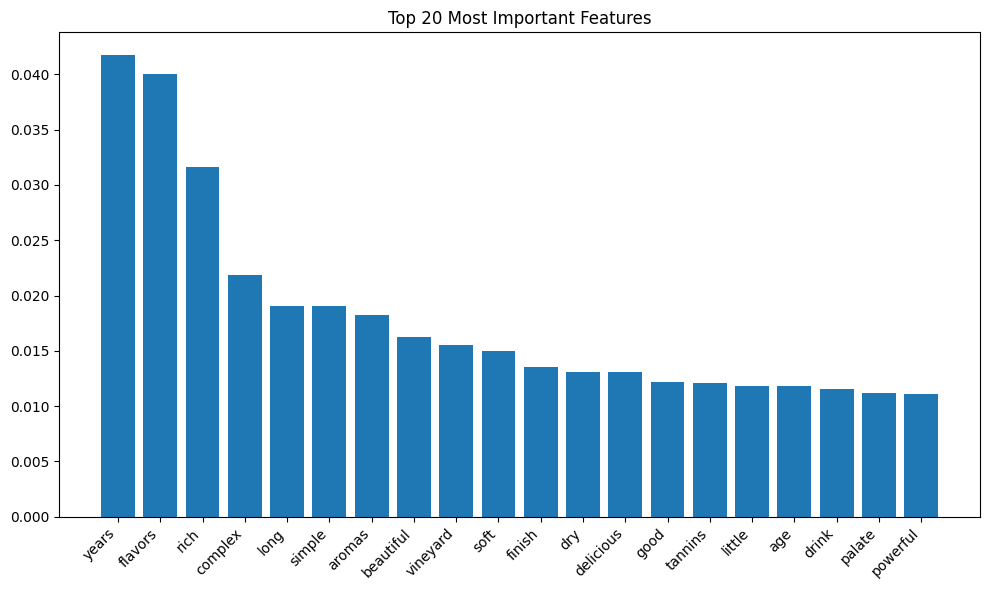


Example Predictions:

Review: An excellent wine with great balance and complexity. Rich flavors of dark fruit and oak.
Prediction: Liked
Confidence: 0.533

Review: Simple and straightforward. Somewhat bland with little character.
Prediction: Not Liked
Confidence: 0.294

Review: Amazing depth with perfect tannins. A masterpiece of winemaking.
Prediction: Not Liked
Confidence: 0.490


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import joblib

class WineReviewClassifier:
    def __init__(self, vocab_size=5000, max_features=5000):
        """
        Initialize the Wine Review Classifier

        Parameters:
        -----------
        vocab_size : int, optional (default=5000)
            Maximum number of features to consider
        max_features : int, optional (default=5000)
            Maximum number of features for TF-IDF vectorization
        """
        self.vectorizer = TfidfVectorizer(
            max_features=max_features,
            stop_words='english',
            ngram_range=(1, 2)
        )
        self.classifier = RandomForestClassifier(
            n_estimators=300,
            max_depth=20,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42,
            class_weight='balanced'
        )
        self.le = LabelEncoder()

    def prepare_data(self, file_path):

        df = pd.read_csv(file_path)

        df = df[['description', 'points']]

        df['sentiment'] = df['points'].apply(lambda x: 1 if x >= 90 else 0)

        X = df['description'].astype(str)
        y = df['sentiment']

        return X, y

    def train(self, X_train, y_train):

        y_train = self.le.fit_transform(y_train)

        X_train_vectorized = self.vectorizer.fit_transform(X_train)

        self.classifier.fit(X_train_vectorized, y_train)

    def evaluate(self, X, y, dataset_name=''):

        y_encoded = self.le.transform(y)

        X_vectorized = self.vectorizer.transform(X)

        y_pred = self.classifier.predict(X_vectorized)

        accuracy = accuracy_score(y_encoded, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_encoded, y_pred, average='binary'
        )

        if dataset_name:
            print(f"{dataset_name} Set Metrics:")
            # print(f"Accuracy: {accuracy:.4f}")
            # print(f"Precision: {precision:.4f}")
            # print(f"Recall: {recall:.4f}")
            # print(f"F1 Score: {f1:.4f}\n")
            print(f"\n{dataset_name} Set Classification Report:")
            print(classification_report(y_encoded, y_pred, target_names=['Not Liked (0)', 'Liked (1)']))
            # if plot_confusion_matrix:
            cm = confusion_matrix(y_encoded, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'{dataset_name} Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

    def plot_accuracies(self, train_acc, val_acc, test_acc):

        plt.figure(figsize=(10, 6))
        sets = ['Train', 'Validation', 'Test']
        accuracies = [train_acc, val_acc, test_acc]

        plt.bar(sets, accuracies, color=['blue', 'green', 'red'])
        plt.title('Model Accuracy Across Different Datasets')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)  # Set y-axis from 0 to 1

        # Add value labels on top of each bar
        for i, v in enumerate(accuracies):
            plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def feature_importance(self):
        """
        Extract and visualize feature importances
        """
        # Get feature names
        feature_names = self.vectorizer.get_feature_names_out()

        # Extract feature importances
        importances = self.classifier.feature_importances_
        indices = np.argsort(importances)[::-1]

        # Plot top 20 features
        plt.figure(figsize=(10, 6))
        plt.title("Top 20 Most Important Features")
        plt.bar(range(20), importances[indices[:20]])
        plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def predict(self, review_text):

        # Vectorize input
        review_vectorized = self.vectorizer.transform([review_text])

        # Predict
        prediction = self.classifier.predict(review_vectorized)
        probability = self.classifier.predict_proba(review_vectorized)[0][1]

        return prediction[0], probability

def main():
    # Initialize classifier
    classifier = WineReviewClassifier()

    # Load and prepare data
    file_path = "winemag-data_first150k.csv"  # Update with your file path
    X, y = classifier.prepare_data(file_path)

    # First split: separate out test set (20%)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Second split: separate train (70%) and validation (10%) sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.125, random_state=42, stratify=y_train_val
    )

    # Train the model
    classifier.train(X_train, y_train)

    # Evaluate performance on all sets
    train_metrics = classifier.evaluate(X_train, y_train, 'Training')
    val_metrics = classifier.evaluate(X_val, y_val, 'Validation')
    test_metrics = classifier.evaluate(X_test, y_test, 'Test')

    # Plot accuracies
    classifier.plot_accuracies(
        train_metrics['accuracy'],
        val_metrics['accuracy'],
        test_metrics['accuracy']
    )

    # Visualize feature importance
    classifier.feature_importance()

    # Example predictions
    example_reviews = [
        "An excellent wine with great balance and complexity. Rich flavors of dark fruit and oak.",
        "Simple and straightforward. Somewhat bland with little character.",
        "Amazing depth with perfect tannins. A masterpiece of winemaking."
    ]

    print("\nExample Predictions:")
    for review in example_reviews:
        prediction, probability = classifier.predict(review)
        print(f"\nReview: {review}")
        print(f"Prediction: {'Liked' if prediction == 1 else 'Not Liked'}")
        print(f"Confidence: {probability:.3f}")

    # Save model and vectorizer
    joblib.dump(classifier.classifier, 'wine_review_rf_model.joblib')
    joblib.dump(classifier.vectorizer, 'wine_review_vectorizer.joblib')

if __name__ == "__main__":
    main()

Training Set Metrics:

Training Set Classification Report:
               precision    recall  f1-score   support

Not Liked (0)       0.90      0.82      0.86     71904
    Liked (1)       0.67      0.81      0.74     33747

     accuracy                           0.82    105651
    macro avg       0.79      0.82      0.80    105651
 weighted avg       0.83      0.82      0.82    105651



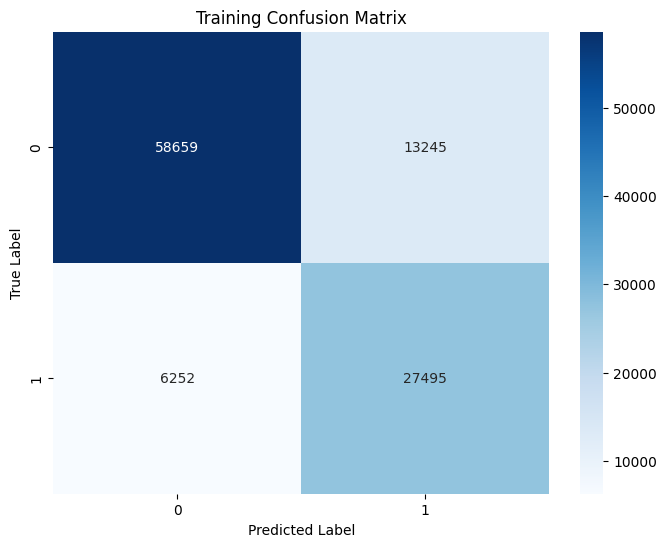

Validation Set Metrics:

Validation Set Classification Report:
               precision    recall  f1-score   support

Not Liked (0)       0.89      0.80      0.84     10272
    Liked (1)       0.65      0.78      0.71      4821

     accuracy                           0.79     15093
    macro avg       0.77      0.79      0.78     15093
 weighted avg       0.81      0.79      0.80     15093



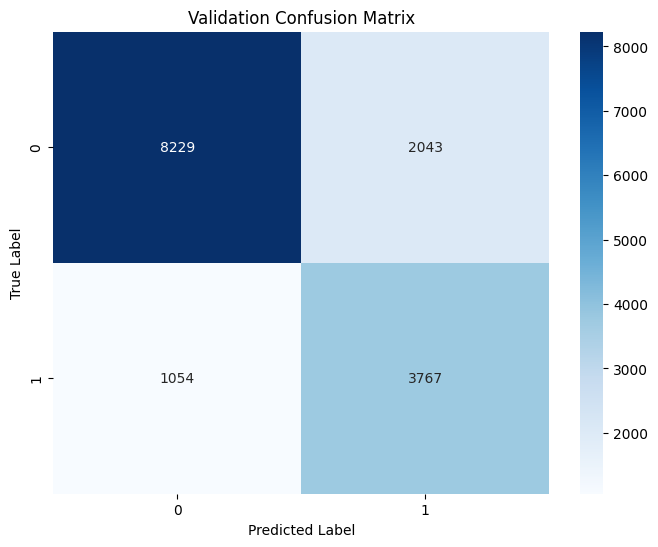

Test Set Metrics:

Test Set Classification Report:
               precision    recall  f1-score   support

Not Liked (0)       0.89      0.80      0.84     20544
    Liked (1)       0.65      0.79      0.71      9642

     accuracy                           0.80     30186
    macro avg       0.77      0.80      0.78     30186
 weighted avg       0.81      0.80      0.80     30186



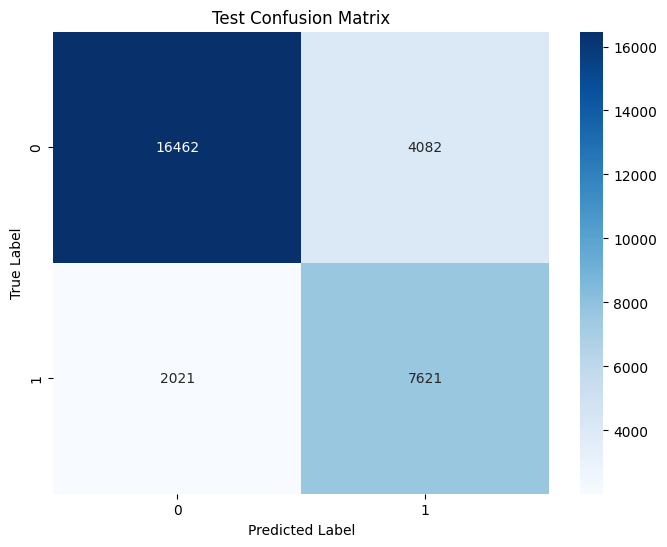

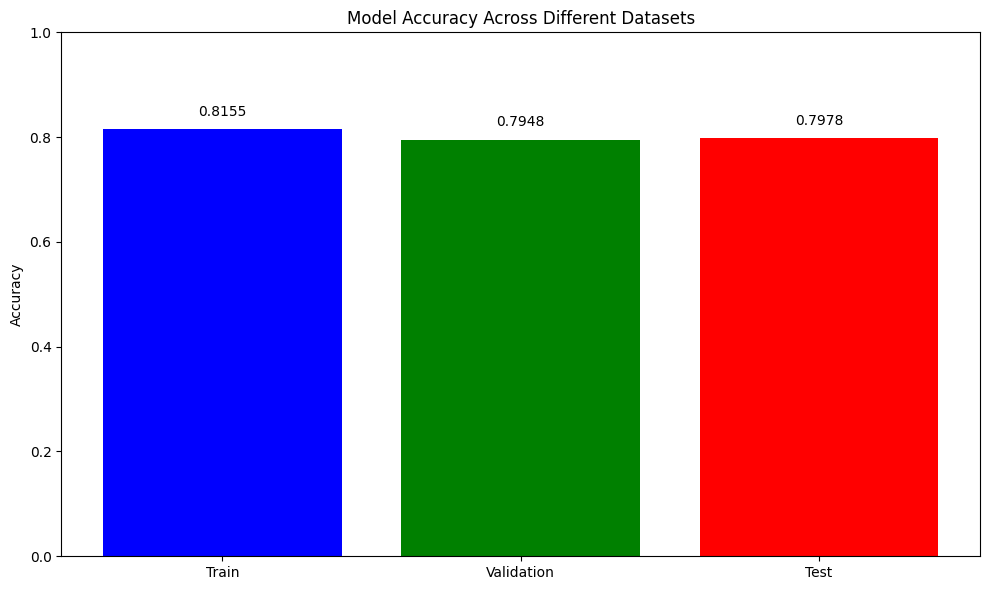

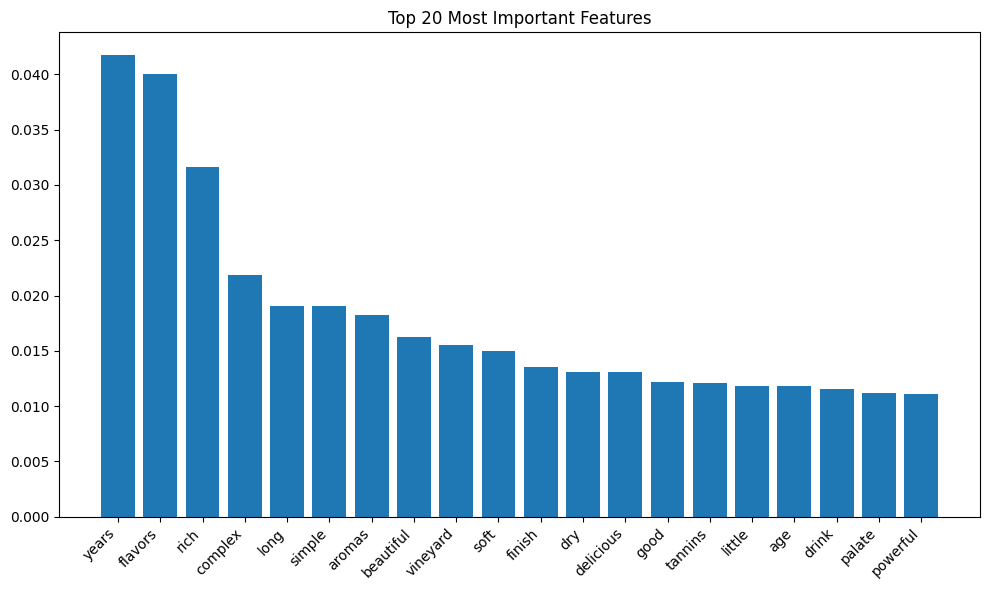


Example Predictions:

Review: An excellent wine with great balance and complexity. Rich flavors of dark fruit and oak.
Prediction: Liked
Confidence: 0.533

Review: Simple and straightforward. Somewhat bland with little character.
Prediction: Not Liked
Confidence: 0.294

Review: Amazing depth with perfect tannins. A masterpiece of winemaking.
Prediction: Not Liked
Confidence: 0.490


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import joblib

class WineReviewClassifier:
    def __init__(self, vocab_size=5000, max_features=5000):

        self.vectorizer = TfidfVectorizer(
            max_features=max_features,
            stop_words='english',
            ngram_range=(1, 2)
        )
        self.classifier = RandomForestClassifier(
            n_estimators=300,
            max_depth=20,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42,
            class_weight='balanced'
        )
        self.le = LabelEncoder()

    def prepare_data(self, file_path):

        # Load dataset
        df = pd.read_csv(file_path)

        # Keep only relevant columns
        df = df[['description', 'points']]

        # Convert ratings to binary sentiment
        df['sentiment'] = df['points'].apply(lambda x: 1 if x >= 90 else 0)

        # Prepare features and labels
        X = df['description'].astype(str)
        y = df['sentiment']

        return X, y

    def train(self, X_train, y_train):

        # Convert labels
        y_train = self.le.fit_transform(y_train)

        # Vectorize text
        X_train_vectorized = self.vectorizer.fit_transform(X_train)

        # Train Random Forest classifier
        self.classifier.fit(X_train_vectorized, y_train)

    def evaluate(self, X, y, dataset_name=''):

        # Convert labels
        y_encoded = self.le.transform(y)

        # Vectorize text
        X_vectorized = self.vectorizer.transform(X)

        # Predictions
        y_pred = self.classifier.predict(X_vectorized)

        # Performance metrics
        accuracy = accuracy_score(y_encoded, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_encoded, y_pred, average='binary'
        )

        # Print metrics if dataset name is provided
        if dataset_name:
            print(f"{dataset_name} Set Metrics:")
            # print(f"Accuracy: {accuracy:.4f}")
            # print(f"Precision: {precision:.4f}")
            # print(f"Recall: {recall:.4f}")
            # print(f"F1 Score: {f1:.4f}\n")
            print(f"\n{dataset_name} Set Classification Report:")
            print(classification_report(y_encoded, y_pred, target_names=['Not Liked (0)', 'Liked (1)']))
            # if plot_confusion_matrix:
            cm = confusion_matrix(y_encoded, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'{dataset_name} Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

    def plot_accuracies(self, train_acc, val_acc, test_acc):

        plt.figure(figsize=(10, 6))
        sets = ['Train', 'Validation', 'Test']
        accuracies = [train_acc, val_acc, test_acc]

        plt.bar(sets, accuracies, color=['blue', 'green', 'red'])
        plt.title('Model Accuracy Across Different Datasets')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)  # Set y-axis from 0 to 1

        # Add value labels on top of each bar
        for i, v in enumerate(accuracies):
            plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def feature_importance(self):
        """
        Extract and visualize feature importances
        """
        # Get feature names
        feature_names = self.vectorizer.get_feature_names_out()

        # Extract feature importances
        importances = self.classifier.feature_importances_
        indices = np.argsort(importances)[::-1]

        # Plot top 20 features
        plt.figure(figsize=(10, 6))
        plt.title("Top 20 Most Important Features")
        plt.bar(range(20), importances[indices[:20]])
        plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def predict(self, review_text):

        # Vectorize input
        review_vectorized = self.vectorizer.transform([review_text])

        # Predict
        prediction = self.classifier.predict(review_vectorized)
        probability = self.classifier.predict_proba(review_vectorized)[0][1]

        return prediction[0], probability

def main():
    # Initialize classifier
    classifier = WineReviewClassifier()

    # Load and prepare data
    file_path = "winemag-data_first150k.csv"  # Update with your file path
    X, y = classifier.prepare_data(file_path)

    # First split: separate out test set (20%)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Second split: separate train (70%) and validation (10%) sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.125, random_state=42, stratify=y_train_val
    )

    # Train the model
    classifier.train(X_train, y_train)

    # Evaluate performance on all sets
    train_metrics = classifier.evaluate(X_train, y_train, 'Training')
    val_metrics = classifier.evaluate(X_val, y_val, 'Validation')
    test_metrics = classifier.evaluate(X_test, y_test, 'Test')

    # Plot accuracies
    classifier.plot_accuracies(
        train_metrics['accuracy'],
        val_metrics['accuracy'],
        test_metrics['accuracy']
    )

    # Visualize feature importance
    classifier.feature_importance()

    # Example predictions
    example_reviews = [
        "An excellent wine with great balance and complexity. Rich flavors of dark fruit and oak.",
        "Simple and straightforward. Somewhat bland with little character.",
        "Amazing depth with perfect tannins. A masterpiece of winemaking."
    ]

    print("\nExample Predictions:")
    for review in example_reviews:
        prediction, probability = classifier.predict(review)
        print(f"\nReview: {review}")
        print(f"Prediction: {'Liked' if prediction == 1 else 'Not Liked'}")
        print(f"Confidence: {probability:.3f}")

    # Save model and vectorizer
    joblib.dump(classifier.classifier, 'wine_review_rf_model.joblib')
    joblib.dump(classifier.vectorizer, 'wine_review_vectorizer.joblib')

if __name__ == "__main__":
    main()